In [1]:
pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import tensorflow_probability as tfp
import pandas as pd
import keras
import keras_tuner as kt
import tf_keras
from datetime import datetime
import os

# Data

<Axes: >

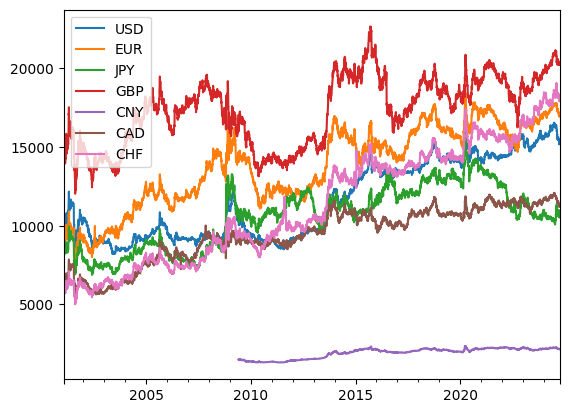

In [3]:
# Membuka file CSV untuk Kurs Transaksi
exrate = pd.read_csv("/content/drive/Othercomputers/My MacBook Air/Tugas Akhir/Sidang Skripsi/Data Bersih/Kurs Transaksi.csv", index_col=0)
exrate = exrate.set_index(pd.to_datetime(exrate.index))
exrate = exrate.astype(np.float32)
exrate.plot()

In [4]:
# # Bagi exrate menjadi train, validation, and test untuk kedua bagian data

len_exrate = len(exrate)
len_train = int(len_exrate*0.7)
len_val = int(len_exrate*0.15)
len_test = len_exrate - len_train - len_val

exrate_train = exrate[:len_train]
exrate_val = exrate[len_train:len_train+len_val]
exrate_test = exrate[len_train+len_val:]

print(f"Length of Train: {len(exrate_train)} from {exrate_train.index.min()} to {exrate_train.index.max()}")
print(f"Length of Val: {len(exrate_val)} from {exrate_val.index.min()} to {exrate_val.index.max()}")
print(f"Length of Test: {len(exrate_test)} from {exrate_test.index.min()} to {exrate_test.index.max()}")

Length of Train: 4325 from 2001-01-24 00:00:00 to 2017-08-22 00:00:00
Length of Val: 926 from 2017-08-23 00:00:00 to 2021-03-10 00:00:00
Length of Test: 928 from 2021-03-11 00:00:00 to 2024-09-30 00:00:00


In [5]:
# Membuat fungsi dataset

def create_dataset(series, input_length, output_length, batch_size=128):
  total_length = input_length + output_length

  dataset = tf.data.Dataset.from_tensor_slices(np.expand_dims(series,-1))
  dataset = dataset.window(total_length, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(total_length))
  dataset = dataset.map(lambda window: (window[:input_length],
                                        tf.expand_dims(window[input_length-1],-1),
                                        window[input_length:],
                                        tf.reduce_mean(window[:input_length],-2,True),
                                        tf.math.reduce_std(window[:input_length],-2,True)))
  dataset = dataset.map(lambda window1, window2, window3, mean, var:
                        (((window1-mean)/var,(window2-mean)/var,(window3-mean)/var, mean, var),(window3-mean)/var))

  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(2)
  return dataset

In [6]:
# Dataset Train

input_length = 100
output_length = 30

train_dataset = create_dataset(exrate_train["USD"].dropna(), input_length, output_length)

for [x,y, a, b, c], z in train_dataset.take(1):
    print("Input1:", x.numpy().shape, "Input2:", y.numpy().shape, "Input3:", a.numpy().shape,
          "Input4:", b.numpy().shape, "Input5:", c.numpy().shape, "Target:", z.numpy().shape)

Input1: (128, 100, 1) Input2: (128, 1, 1) Input3: (128, 30, 1) Input4: (128, 1, 1) Input5: (128, 1, 1) Target: (128, 30, 1)


In [7]:
# Dataset Validation

input_length = 100
output_length = 30

val_dataset = create_dataset(exrate_val["USD"].dropna(), input_length, output_length)

for [x,y, a, b, c], z in val_dataset.take(1):
    print("Input1:", x.numpy().shape, "Input2:", y.numpy().shape, "Input3:", a.numpy().shape,
          "Input4:", b.numpy().shape, "Input5:", c.numpy().shape, "Target:", z.numpy().shape)

Input1: (128, 100, 1) Input2: (128, 1, 1) Input3: (128, 30, 1) Input4: (128, 1, 1) Input5: (128, 1, 1) Target: (128, 30, 1)


In [8]:
# Dataset Test

input_length = 100
output_length = 30

test_dataset = create_dataset(exrate_test["USD"].dropna(), input_length, output_length)


for [x,y, a, b, c], z in test_dataset.take(1):
    print("Input1:", x.numpy().shape, "Input2:", y.numpy().shape, "Input3:", a.numpy().shape,
          "Input4:", b.numpy().shape, "Input5:", c.numpy().shape, "Target:", z.numpy().shape)

Input1: (128, 100, 1) Input2: (128, 1, 1) Input3: (128, 30, 1) Input4: (128, 1, 1) Input5: (128, 1, 1) Target: (128, 30, 1)


In [9]:
def custom_loss(y_true,y_pred):
    dfs, locs, scales, mean, std, _ = tf.split(y_pred, 6, axis=-1)
    dist = tfp.distributions.StudentT(df=dfs, loc=locs, scale=scales)
    time_sum = tf.reduce_sum(dist.log_prob(y_true), axis=-2)
    loss = -tf.reduce_mean(time_sum)
    return loss

In [10]:
def mape_unnormalize(y_true, y_pred):
    dfs, locs, scales, mean, std, _ = tf.split(y_pred, 6, axis=-1)
    dist = tfp.distributions.StudentT(df=dfs, loc=locs, scale=scales)
    y_pred_mean = dist.mode()

    return tf.keras.losses.MAPE(y_true*std+mean, y_pred_mean*std+mean)

In [11]:
def rmse_unnormalize(y_true, y_pred):
    dfs, locs, scales, mean, std, _ = tf.split(y_pred, 6, axis=-1)
    dist = tfp.distributions.StudentT(df=dfs, loc=locs, scale=scales)
    y_pred_mean = dist.mode()

    return tf.sqrt(tf.keras.losses.MSE(y_true*std+mean, y_pred_mean*std+mean))

In [12]:
def rho_risk_upper(y_true, y_pred):
    dfs, locs, scales, mean, std, _ = tf.split(y_pred, 6, axis=-1)
    dist = tfp.distributions.StudentT(df=dfs, loc=locs, scale=scales)

    rho = 0.975

    y_quantile = dist.quantile(rho) * std + mean
    y_true = y_true * std + mean

    y_true_sum = tf.reduce_sum(y_true, axis=-2)
    y_quantile_sum = tf.reduce_sum(y_quantile, axis=-2)

    cond_great = tf.greater(y_true_sum,y_quantile_sum)
    cond_great = tf.where(cond_great, 1.0, 0.0)

    cond_less = tf.less_equal(y_true_sum,y_quantile_sum)
    cond_less = tf.where(cond_less, 1.0, 0.0)

    loss_quantile = 2 * (y_true_sum-y_quantile_sum) * (rho*cond_great-(1-rho)*cond_less)

    return tf.reduce_mean(loss_quantile)

In [13]:
def rho_risk_lower(y_true, y_pred):
    dfs, locs, scales, mean, std, _ = tf.split(y_pred, 6, axis=-1)
    dist = tfp.distributions.StudentT(df=dfs, loc=locs, scale=scales)

    rho = 0.025

    y_quantile = dist.quantile(rho) * std + mean
    y_true = y_true * std + mean

    y_true_sum = tf.reduce_sum(y_true, axis=-2)
    y_quantile_sum = tf.reduce_sum(y_quantile, axis=-2)

    cond_great = tf.greater(y_true_sum,y_quantile_sum)
    cond_great = tf.where(cond_great, 1.0, 0.0)

    cond_less = tf.less_equal(y_true_sum,y_quantile_sum)
    cond_less = tf.where(cond_less, 1.0, 0.0)

    loss_quantile = 2 * (y_true_sum-y_quantile_sum) * (rho*cond_great-(1-rho)*cond_less)

    return tf.reduce_mean(loss_quantile)

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Lambda, Concatenate, Attention, Reshape, AdditiveAttention, Layer
from tensorflow.keras import backend as K

class Sampling(Layer):
  def call(self, x):
    dist = tfp.distributions.StudentT(df=x[0], loc=x[1], scale=x[2])
    return dist.sample()

def model_builder(hp):
  hp_latent_dim = hp.Choice('latent_dim', values=[2**(i+2) for  i in range(5)])
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001])

  # The first part is unchanged
  encoder_inputs = Input(name="input_1", shape=(None, 1))
  mean_inputs = Input(name="input_2", shape=(1, 1))
  std_inputs = Input(name="input_3", shape=(1, 1))
  decoder_outputs_true = Input(name="input_4", shape=(None, 1))

  encoder_1 = GRU(hp_latent_dim, return_sequences=True, return_state=True)

  encoder_1_outputs, state_h_1 = encoder_1(encoder_inputs)

  # Set up the decoder, which will only process one timestep at a time.
  decoder_inputs = Input(shape=(1, 1))
  decoder_1 = GRU(hp_latent_dim, return_sequences=True, return_state=True)


  decoder_dense_df = Dense(1, activation="softplus")
  decoder_dense_loc = Dense(1)
  decoder_dense_scale = Dense(1, activation="softplus")

  sampling = Sampling()

  concat = Concatenate(axis=-1)

  all_outputs = []
  inputs = decoder_inputs
  for _ in range(output_length):

      # Run the decoder on one timestep
      decoder_1_outputs, state_h_1 = decoder_1(inputs,
                                              initial_state=state_h_1)



      outputs_df = decoder_dense_df(decoder_1_outputs)
      outputs_loc = decoder_dense_loc(decoder_1_outputs)
      outputs_scale = decoder_dense_scale(decoder_1_outputs)

      z = sampling([outputs_df, outputs_loc, outputs_scale])

      outputs = concat([outputs_df, outputs_loc, outputs_scale, mean_inputs, std_inputs])

      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = z

  # Concatenate all predictions
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  decoder_outputs = concat([decoder_outputs, decoder_outputs_true])


  # Define and compile model as previously
  model = Model([encoder_inputs, decoder_inputs, decoder_outputs_true, mean_inputs, std_inputs], decoder_outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=custom_loss,
                metrics = [mape_unnormalize, rmse_unnormalize, rho_risk_upper, rho_risk_lower])

  return model

In [15]:
model_number = "11"
now = datetime.now()


tuner = kt.GridSearch(model_builder,
                     objective='val_loss',
                    directory=f'/content/drive/Othercomputers/My MacBook Air/Tugas Akhir/Sidang Skripsi/Pemodelan/Keras Tuner/{model_number}',
                     project_name="20241119022635")

print(now.strftime("%Y%m%d%H%M%S"))

Reloading Tuner from /content/drive/Othercomputers/My MacBook Air/Tugas Akhir/Sidang Skripsi/Pemodelan/Keras Tuner/11/20241119022635/tuner0.json
20241122224135


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tensor_board_dir = os.path.join(f'/content/drive/Othercomputers/My MacBook Air/Tugas Akhir/Sidang Skripsi/Pemodelan/TensorBoard/{model_number}', now.strftime("%Y%m%d%H%M%S"))

tensor_board = tf.keras.callbacks.TensorBoard(tensor_board_dir)
tuner.search(train_dataset, validation_data=val_dataset, shuffle=True, epochs=150, callbacks=[stop_early, tensor_board])

Trial 10 Complete [00h 09m 33s]
val_loss: 48.73115921020508

Best val_loss So Far: 47.65848922729492
Total elapsed time: 01h 39m 04s


In [ ]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/Othercomputers/My MacBook Air/Tugas Akhir/Sidang Skripsi/Pemodelan/Keras Tuner/11/20241119022635
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 0000 summary
Hyperparameters:
latent_dim: 4
learning_rate: 0.01
Score: 47.65848922729492

Trial 0003 summary
Hyperparameters:
latent_dim: 8
learning_rate: 0.001
Score: 47.781898498535156

Trial 0007 summary
Hyperparameters:
latent_dim: 32
learning_rate: 0.001
Score: 47.81407165527344


In [16]:
best_model = tuner.get_best_models()[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]

In [17]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, None, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 1, 1)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ [(None, None, 4),      │             84 │ input_1[0][0]          │
│                           │ (None, 4)]             │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ [(None, 1, 4), (None,  │             84 │ input_layer[0][0],     │
│                           │ 4)]                    │                │ gru[0][1],             │
│                           │                        │                │ sampling[0][0],        │
│                           │                        │                │ gru_1[0][1],           │
│                           │                        │                │ sampling[1][0],        │
│                           │                        │                │ gru_1[1][1],           │
│                           │                        │                │ sampling[2][0],        │
│                           │                        │                │ gru_1[2][1],           │
│                           │                        │                │ sampling[3][0],        │
│                           │                        │                │ gru_1[3][1],           │
│                           │                        │                │ sampling[4][0],        │
│                           │                        │                │ gru_1[4][1],           │
│                           │                        │                │ sampling[5][0],        │
│                           │                        │                │ gru_1[5][1],           │
│                           │                        │                │ sampling[6][0],        │
│                           │                        │                │ gru_1[6][1],           │
│                           │                        │                │ sampling[7][0],        │
│                           │                        │                │ gru_1[7][1],           │
│                           │                        │                │ sampling[8][0],        │
│                           │                        │                │ gru_1[8][1],           │
│                           │                        │                │ sampling[9][0],        │
│                           │                        │                │ gru_1[9][1],           │
│                           │                        │                │ sampling[10][0],       │
│                           │                        │                │ gru_1[10][1],          │
│                           │                        │                │ sampling[11][0],       │
│                           │                        │                │ gru_1[11][1],          │
│                           │                        │                │ sampling[12][0],       │
│                           │                        │                │ gru_1[12][1],          │
│                           │                        │                │ sampling[13][0],       │
│                           │                        │                │ gru_1[13][1],          │
│                           │                        │                │ sampling[14][0],       │
│                      

 Total params: 183 (732.00 B)

 Trainable params: 183 (732.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_number = "11"
now = datetime.now()

model_name = now.strftime("%Y%m%d%H%M%S")+"_"+str(best_hps.get("latent_dim"))+"_"+str(best_hps.get("learning_rate"))+"_"+tuner.oracle.get_best_trials()[0].trial_id

print(model_name)

best_model.save_weights(f"/content/drive/Othercomputers/My MacBook Air/Tugas Akhir/Sidang Skripsi/Pemodelan/Weights/{model_number}/"+model_name+".weights.h5")

20241119040801_4_0.01_0000


In [ ]:
best_model.evaluate(train_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - loss: 44.0187 - mape_unnormalize: 2.2426 - rho_risk_lower: 1441.8218 - rho_risk_upper: 1389.0135 - rmse_unnormalize: 216.2974


[43.81039810180664,
 1.6386271715164185,
 169.1837158203125,
 1142.028076171875,
 1029.9754638671875]

In [ ]:
best_model.evaluate(val_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 48.2047 - mape_unnormalize: 1.4425 - rho_risk_lower: 1084.2723 - rho_risk_upper: 1774.2262 - rmse_unnormalize: 210.4362


[47.64360427856445,
 1.6786603927612305,
 247.79232788085938,
 2135.672607421875,
 1092.6153564453125]

In [ ]:
best_model.evaluate(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 46.7517 - mape_unnormalize: 0.8861 - rho_risk_lower: 757.9274 - rho_risk_upper: 810.7129 - rmse_unnormalize: 133.5813


[46.89033508300781,
 1.0355172157287598,
 158.87042236328125,
 874.046630859375,
 945.5582275390625]

In [ ]:
%reload_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/Othercomputers/My MacBook Air/Tugas Akhir/Sidang Skripsi/Pemodelan/TensorBoard/11/20241119022635

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-11-19 04:11:17.157318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 04:11:17.196020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 04:11:17.207977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 04:11:19.250637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f